Show effectiveness of FastGradientMethod for generating minimal adv examples.
Using IBM ART (adversarial-robustness-toolbox). Check out the [source code and demo](https://github.com/IBM/adversarial-robustness-toolbox/tree/master/art) here.

This notebook combines two graphs for running the wakeword detector from audio. A pre-processing stft tf-graph and the loaded trained network

In [1]:
import glob
import os

import numpy as np
import tensorflow as tf
import pydub
import librosa
import matplotlib.pyplot as plt
import matplotlib as mpl

from art.attacks.evasion import FastGradientMethod, AutoProjectedGradientDescent, UniversalPerturbation
from art.estimators.classification import TensorFlowClassifier

import warnings
warnings.filterwarnings('ignore')
# import spec2audio as sta
from IPython.display import Audio

In [2]:
plt.style.use('ggplot')

In [3]:
from augment_audio import scale_to_peak_windowed_dBFS
from util.ft import unnormalize_0_1

### 0. Read speech examples

In [4]:
# TF_RECORD_DIR = '/scratch1/ilya/locDoc/data/alexa/v7.15/val_19680_positive'
TF_RECORD_DIR = '/scratch1/ilya/locDoc/data/alexa/v7.16/val_21280_positive'
tfrecord_files = glob.glob(os.path.join(TF_RECORD_DIR, '*.tfrecord'))
tfrecord_file = tfrecord_files[0]
mean = 0.3715735405001496
std_dev = 0.2031791745456392

In [5]:
def prep(S):
    S = S - mean
    S = S / std_dev
    return S

def unprocS(S):
    S = S * std_dev
    S = S + mean
    return S**(1/0.3)

In [6]:
spec_h = 257 # 80
# set some variables that are relavant to the network
# network_example_length = 19840
# hop_length = 160

examples = []
specs = []
spec_labs = []
audio_labs = []
limit = 100

# for tfrecord_file in tfrecord_files:
for i, example in enumerate(tf.python_io.tf_record_iterator(tfrecord_file)):
    if i < 20:
        continue
    eg_np = tf.train.Example.FromString(example)
    audio_segment = pydub.AudioSegment(
        eg_np.features.feature["audio"].bytes_list.value[0], 
        frame_rate=16000,
        sample_width=2, 
        channels=1
    )
    y = audio_segment.get_array_of_samples()
    examples.append(y)

    spec = eg_np.features.feature["spectrogram"].float_list.value
    spec = np.array(spec).reshape(spec_h,-1)
    specs.append(spec)
    
    spec_labs.append(eg_np.features.feature["spectrogram_label"].int64_list.value)
    
    audio_labs.append(eg_np.features.feature["audio_label"].int64_list.value)
    
    if i > limit:
        break

Instructions for updating:
Use eager execution and: 
`tf.data.TFRecordDataset(path)`


In [7]:
examples = np.array(examples)
specs = np.array(specs, dtype=np.float32)
spec_labs = np.array(spec_labs)
print(examples.shape)
print(specs.shape)

(61, 21280)
(61, 257, 134)


In [8]:
min_input_value, max_input_value = -1,1

In [9]:
print(len(spec_labs[0]))

134


In [10]:
sound_i = 1
Audio(examples[sound_i], rate=16000)

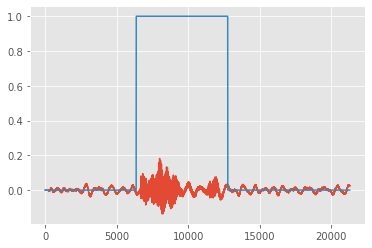

In [11]:
# sound_i += 1
plt.plot(np.array(examples[sound_i]) / 2**15)
plt.plot(audio_labs[sound_i])

### 1. Slice the training examples to feed time-domain input into a network (which will be size 31 in the spectral domain)

In [12]:
n_fft = 512
hop_length = 160
win_length = 400

batch_item_length = n_fft-hop_length + hop_length*31

In [13]:
# split a single sound into all possible pieces
y = examples[sound_i] / 2**15
yp = np.pad(y, int(n_fft // 2), mode='reflect')


n_items_in_y = (len(yp) - batch_item_length) // hop_length

batched_input = []
batched_labels = spec_labs[sound_i,21:-10]
for i in range(n_items_in_y):
    start = i*hop_length
    end = start + batch_item_length
    batched_input.append(yp[start:end])

In [13]:
# split a bunch of sounds into non-overlapping pieces - in the case of the val set this is 4 pieces
batched_input = []
batched_labels = []
bs = 128
for i in range(min(bs // 4, len(examples))):
    y = examples[i] / 2**15
#     yp = np.pad(y, int(n_fft // 2), mode='reflect')
    yp=y
    for j in range(4):
        batched_input.append(yp[(j*batch_item_length):((j+1)*batch_item_length)])
        batched_labels.append(audio_labs[i][(j*batch_item_length) + 2*(batch_item_length//3)])


In [14]:
batched_input = np.array(batched_input)
batched_labels = np.array(batched_labels)
batched_input.shape

(128, 5312)

In [15]:
mid = len(batched_input) // 2 

batched_input_other = batched_input[mid:]
batched_labels_other = batched_labels[mid:]

batched_input = batched_input[:mid]
batched_labels = batched_labels[:mid]

## 2. Load wake word detection model

If you switch network models to load, it is best to restart the kernel

In [16]:
with tf.Graph().as_default() as g_1:
#     model_dir = '/scratch0/ilya/locDownloads/temp_7.15_model/baseline_tfspecv715_bs64_trial2/export/best_loss_exporter/1600571029/'
#     model_dir = '/scratch0/ilya/locDownloads/temp_7.15_cort_res_model/export/FAR_exporter/1601095073/'
    model_dir = '/scratch0/ilya/locDownloads/temp_v715_cortical_model/'
#     model_dir = '/scratch0/ilya/locDownloads/temp_v715_cortical_model_res1b/export/best_acc_exporter/1601144074/'
    model_dir = '/scratch0/ilya/locDownloads/temp_v715_cortical_model_res1c_drop7/export/FAR_exporter/1601427538/'
    with tf.compat.v1.Session(graph=g_1) as sess:
        model = tf.saved_model.loader.load(sess, [tf.saved_model.tag_constants.SERVING], model_dir)
        predictor = tf.contrib.predictor.from_saved_model(model_dir)
        
        signature = model.signature_def
        signature_key = "serving_default"
        input_key = "spectrograms"
        output_key = "logits"

        x_tensor_name = signature[signature_key].inputs[input_key].name
        y_tensor_name = signature[signature_key].outputs[output_key].name

        input_ph = sess.graph.get_tensor_by_name(x_tensor_name)
        logits = sess.graph.get_tensor_by_name(y_tensor_name)
        flat_logits = tf.reshape(logits, [-1,3], name='flat_logits') # just gets rid of middle time dimension which is equal to 1 in the output 31 case
        
        saver = tf.train.Saver()
        saver.save(sess, "/scratch0/ilya/locDownloads/temp3/model7.15_resave.ckpt")

Instructions for updating:
This function will only be available through the v1 compatibility library as tf.compat.v1.saved_model.loader.load or tf.compat.v1.saved_model.load. There will be a new function for importing SavedModels in Tensorflow 2.0.
INFO:tensorflow:Restoring parameters from /scratch0/ilya/locDownloads/temp_v715_cortical_model_res1c_drop7/export/FAR_exporter/1601427538/variables/variables
The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

INFO:tensorflow:Restoring parameters from /scratch0/ilya/locDownloads/temp_v715_cortical_model_res1c_drop7/export/FAR_exporter/1601427538/variables/variables


### Construct the preprocessing graph

In [17]:
from util.librosa import librosa_window_fn

In [18]:
def mywindow_fn(argi, dtype):
    """
    argi is the length of the window that is returned. In this case it is
    n_fft. The window returned will be a win_length window zero padded to
    be n_fft long.
    """
    del argi
    return tf.convert_to_tensor(librosa_window_fn(win_length, n_fft), dtype=dtype)

In [19]:
with tf.Graph().as_default() as g_2:
    input_td_placeholder = tf.placeholder(tf.float32, shape=(None, batch_item_length), name='time_input')
    
    spec = tf.signal.stft(
        input_td_placeholder,
        frame_length=n_fft,
        frame_step=hop_length,
        fft_length=n_fft,
        window_fn=mywindow_fn,
        pad_end=False,
        name='STFT'
    )
    spec = tf.abs(spec)
    # Stevens's power law for loudness
    spec = spec**0.3
    spec = tf.transpose(spec, perm=[0,2,1])
    
    # need the global mean/variance normalization here
    spec = tf.subtract(spec, mean)
    spec = tf.divide(spec, std_dev, name='spec_from_time')

### Combine the pre-processing graph with the model graph

In [20]:
from tensorflow.python.framework import meta_graph

In [21]:
g_combined = tf.get_default_graph()
combined_sess = tf.Session(graph=g_combined)
combined_input = tf.placeholder(tf.float32, shape=(None, batch_item_length), name='time_input')

meta_graph2 = tf.train.export_meta_graph(graph=g_2)
meta_graph.import_scoped_meta_graph(meta_graph2, input_map={'time_input': combined_input}, import_scope='g_2')
out1 = g_combined.get_tensor_by_name('g_2/spec_from_time:0')

meta_graph1 = tf.train.export_meta_graph(graph=g_1)
new_saver = meta_graph.import_scoped_meta_graph(meta_graph1, input_map={x_tensor_name: out1}, import_scope=None)

out_final = g_combined.get_tensor_by_name('flat_logits:0')

labels_ph = tf.placeholder(tf.int32, shape=[None, 3])
loss_op = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(
    logits=out_final, labels=labels_ph))

restorer = tf.train.Saver()

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.



In [22]:
# ART library wrapper around the tensorflow model
classifier = TensorFlowClassifier(
    clip_values=(min_input_value, max_input_value),
    input_ph=combined_input,
    output=out_final,
    labels_ph=labels_ph,
    loss=loss_op,
    learning=None,
    sess=combined_sess,
    preprocessing_defences=[],
)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [23]:
combined_sess.run(tf.global_variables_initializer())

In [24]:
restorer.restore(combined_sess, "/scratch0/ilya/locDownloads/temp3/model7.15_resave.ckpt")

INFO:tensorflow:Restoring parameters from /scratch0/ilya/locDownloads/temp3/model7.15_resave.ckpt


## 3. Evaluate the ART classifier on benign val examples

In [25]:
predictions = classifier.predict(batched_input)

In [26]:
labels = batched_labels

In [27]:
mask_acc = (np.argmax(predictions, axis=1) == (labels+1)).sum() / len(labels)
detection_acc = ((np.argmax(predictions, axis=1) == 2) & (labels == 1)).sum() / (labels == 1).sum()
other_acc = ((np.argmax(predictions, axis=1) != 2) & (labels != 1)).sum() / (labels != 1).sum()
print('Mask acc: %.4f, Detection acc: %.4f, Non-wake acc: %.4f' % (mask_acc, detection_acc, other_acc))

Mask acc: 0.9062, Detection acc: 0.8387, Non-wake acc: 1.0000


## 4. Create Adv egs on regular time domain input

### Generate

In [28]:
# Fast Gradient Method
# TODO pick epsilon by SNR, see role of radius here: https://github.com/Trusted-AI/adversarial-robustness-toolbox/blob/307f7c9ec255c9c3594a9e57c82a2b9064c69843/art/utils.py#L195
norm = 2
eps = 0.01
eps_step=0.001
# attack = FastGradientMethod(estimator=classifier, norm=norm, targeted=True, eps=eps, eps_step=eps_step, minimal=False)
# attack = AutoProjectedGradientDescent(estimator=classifier, norm=norm, targeted=False, eps=eps, eps_step=eps_step, loss_type='cross_entropy')
attack = UniversalPerturbation(classifier=classifier, delta=0.001, max_iter=20)
adv_egs = attack.generate(x=batched_input, y=batched_labels)

Universal perturbation: 0it [00:00, ?it/s]
DeepFool: 100%|██████████| 1/1 [00:04<00:00,  4.67s/it]

DeepFool: 100%|██████████| 1/1 [00:00<00:00,  9.27it/s]

DeepFool: 100%|██████████| 1/1 [00:00<00:00, 14.95it/s]

DeepFool: 100%|██████████| 1/1 [00:00<00:00, 10.33it/s]

DeepFool: 100%|██████████| 1/1 [00:00<00:00,  4.85it/s]

DeepFool: 100%|██████████| 1/1 [00:00<00:00, 15.05it/s]

DeepFool: 100%|██████████| 1/1 [00:00<00:00, 16.90it/s]

DeepFool: 100%|██████████| 1/1 [00:00<00:00, 15.49it/s]

DeepFool: 100%|██████████| 1/1 [00:00<00:00, 15.61it/s]

DeepFool: 100%|██████████| 1/1 [00:00<00:00, 17.43it/s]

DeepFool: 100%|██████████| 1/1 [00:00<00:00, 15.65it/s]

DeepFool: 100%|██████████| 1/1 [00:00<00:00, 15.82it/s]

DeepFool: 100%|██████████| 1/1 [00:00<00:00, 16.17it/s]

DeepFool: 100%|██████████| 1/1 [00:00<00:00, 15.18it/s]

DeepFool: 100%|██████████| 1/1 [00:00<00:00,  8.56it/s]

DeepFool: 100%|██████████| 1/1 [00:00<00:00, 17.20it/s]

DeepFool: 100%|██████████| 1/1 [00:00<00:00, 

Attacks:
- FG, (norm, eps, eps_step, targeted?)
  + (l2, 1.0, 0.1, targeted) 100% effective on regular network, 10 dB SNR
  + same params on cortical lead to a particular waveform being created
  + (linf, 0.003, 0.001, not targeted and miniaml), on normal and cortical, just creates oscillating signal of +/- eps. Low power and not audible
- AutoProjectedGradientDescent
 + (linf, 0.001, 0.0001, not targeted) 100% effective on regular network at 33dB SNR
 + (linf, 0.0001, 0.00001, not targeted) 81% -> 75%, 53 dB SNR, on cortical_res1b, 93% -> 30%

### Evaluate

In [37]:
predictions = classifier.predict(batched_input)

In [38]:
print('Before')
n_ww = (np.argmax(predictions, axis=1) == 2).astype(int).sum()
n_other_speech = (np.argmax(predictions, axis=1) == 0).astype(int).sum()
n_silence = (np.argmax(predictions, axis=1) == 1).astype(int).sum()
print('N WW: %i, N Other Speech: %i, N silence: %i' % (n_ww, n_other_speech, n_silence))
mask_acc = (np.argmax(predictions, axis=1) == (labels+1)).sum() / len(labels)
detection_acc = ((np.argmax(predictions, axis=1) == 2) & (labels == 1)).sum() / (labels == 1).sum()
other_acc = ((np.argmax(predictions, axis=1) != 2) & (labels != 1)).sum() / (labels != 1).sum()
print('Mask acc: %.4f, Detection acc: %.4f, Non-wake acc: %.4f' % (mask_acc, detection_acc, other_acc))

Before
N WW: 29, N Other Speech: 2, N silence: 33
Mask acc: 0.8906, Detection acc: 0.9600, Non-wake acc: 0.8718


In [39]:
orig_pred_class = np.argmax(predictions.copy(), axis=1)

predictions = classifier.predict(adv_egs)

adv_pred_class = np.argmax(predictions.copy(), axis=1)
flipped = (orig_pred_class != adv_pred_class).sum()
print('Changed %i/%i predictions, %.2f perc' % (flipped, len(adv_pred_class), 100*flipped / len(adv_pred_class)))

Changed 42/64 predictions, 65.62 perc


In [40]:
print('After')
n_ww = (np.argmax(predictions, axis=1) == 2).astype(int).sum()
n_other_speech = (np.argmax(predictions, axis=1) == 0).astype(int).sum()
n_silence = (np.argmax(predictions, axis=1) == 1).astype(int).sum()
print('N WW: %i, N Other Speech: %i, N silence: %i' % (n_ww, n_other_speech, n_silence))
mask_acc = (np.argmax(predictions, axis=1) == (labels+1)).sum() / len(labels)
detection_acc = ((np.argmax(predictions, axis=1) == 2) & (labels == 1)).sum() / (labels == 1).sum()
other_acc = ((np.argmax(predictions, axis=1) != 2) & (labels != 1)).sum() / (labels != 1).sum()
print('Mask acc: %.4f, Detection acc: %.4f, Non-wake acc: %.4f' % (mask_acc, detection_acc, other_acc))

After
N WW: 19, N Other Speech: 44, N silence: 1
Mask acc: 0.3125, Detection acc: 0.6800, Non-wake acc: 0.9487


In [41]:
Psignal = (batched_input**2).sum()
Pnoise = ((batched_input - adv_egs)**2).sum()
snrdb = 10*np.log10(Psignal/Pnoise)
print('SNR is %f dB' % snrdb)

SNR is 23.868068 dB


### Sub data in evaluation
(Then run above Evaluate section again)

In [34]:
noise = (batched_input - adv_egs)

In [35]:
# apply noise to the second half of the examples
batched_input = batched_input_other
adv_egs = batched_input_other + noise
batched_labels = batched_labels_other

In [36]:
labels = batched_labels

### Inspect

In [42]:
# recombine the quarters
unbatched_adv_egs = []
unbatched_originals = []

for i in range(len(adv_egs)//4):
    y = []
    yo = []
    for j in range(4):
        y.append(adv_egs[i*4 + j])
        yo.append(batched_input[i*4 + j])
    unbatched_adv_egs.append(np.concatenate(y))
    unbatched_originals.append(np.concatenate(yo))



In [43]:
adv_sound_i = 3

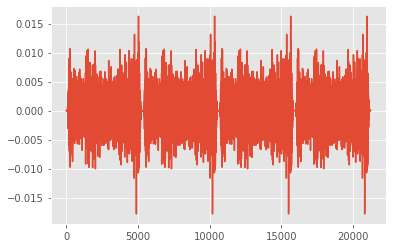

In [44]:
plt.plot(unbatched_adv_egs[adv_sound_i] - unbatched_originals[adv_sound_i])
# plt.xlim([0,100])

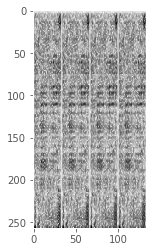

In [45]:
err_sound = unbatched_adv_egs[adv_sound_i] - unbatched_originals[adv_sound_i]
err_stft = librosa.core.stft(err_sound,
        win_length=16000//40,
        hop_length=160,
        n_fft=512)
err_feat = (np.abs(err_stft)**0.3 - mean)/ std_dev
plt.imshow(err_feat,cmap='Greys')
plt.grid(b=None)

In [46]:
Audio(unbatched_originals[adv_sound_i], rate=16000)

In [47]:
Audio(unbatched_adv_egs[adv_sound_i], rate=16000)

In [77]:
Audio(unbatched_adv_egs[adv_sound_i] - unbatched_originals[adv_sound_i], rate=16000)

## Evaluate every subsection of adv audio

In [45]:
yp = unbatched_adv_egs[adv_sound_i]

In [46]:
n_items_in_y = (len(yp) - batch_item_length) // hop_length

batched_input = []
# batched_labels = spec_labs[sound_i,21:-10]
for i in range(n_items_in_y):
    start = i*hop_length
    end = start + batch_item_length
    batched_input.append(yp[start:end])
batched_input = np.array(batched_input)    
batched_input.shape

(99, 5312)

In [47]:
predictions_adv = np.argmax(classifier.predict(batched_input), axis=1)

In [48]:
yp = unbatched_originals[adv_sound_i]

In [49]:
n_items_in_y = (len(yp) - batch_item_length) // hop_length

batched_input = []
batched_labels = spec_labs[sound_i,21:-10]
for i in range(n_items_in_y):
    start = i*hop_length
    end = start + batch_item_length
    batched_input.append(yp[start:end])
batched_input = np.array(batched_input)    
batched_input.shape

(99, 5312)

In [50]:
predictions_og = np.argmax(classifier.predict(batched_input), axis=1)

([<matplotlib.axis.YTick at 0x7ff70373f400>,
 <a list of 3 Text yticklabel objects>)

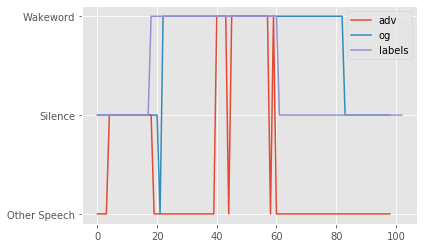

In [51]:
plt.plot(predictions_adv - 1)
plt.plot(predictions_og - 1)
plt.plot(batched_labels)
plt.legend(['adv','og', 'labels'])
plt.yticks([1,0,-1], labels=['Wakeword', 'Silence', 'Other Speech'])

Though the adversarial noise was generated for the signal cut into quarters, it is effective for almost every frame when the adversarial audio is cut up to have highly overlapping windows.

## Performance after quantization

In [52]:
yp = unbatched_adv_egs[adv_sound_i]
yp *= 2**15
yp = np.round(yp) / 2**15

In [53]:
n_items_in_y = (len(yp) - batch_item_length) // hop_length

batched_input = []
# batched_labels = spec_labs[sound_i,21:-10]
for i in range(n_items_in_y):
    start = i*hop_length
    end = start + batch_item_length
    batched_input.append(yp[start:end])
batched_input = np.array(batched_input)    
batched_input.shape

(99, 5312)

In [54]:
predictions_adv_quant = np.argmax(classifier.predict(batched_input), axis=1)

([<matplotlib.axis.YTick at 0x7ff7036526a0>,
 <a list of 3 Text yticklabel objects>)

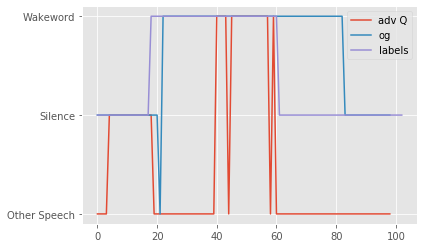

In [55]:
plt.plot(predictions_adv_quant - 1)
plt.plot(predictions_og - 1)
plt.plot(batched_labels)
plt.legend(['adv Q','og', 'labels'])
plt.yticks([1,0,-1], labels=['Wakeword', 'Silence', 'Other Speech'])